# spaCy/HDBScan Feature Extraction Pipeline

### Note: it can be quite complicated to install spaCy and sense2vec, given conflicting low-level requirements, so at this point I wouldn't suggest that others try to install the libraries and run this notebook.
  
However, it is well worth scanning down to the cell titled ***Harvesting Word Features***. In the output of that cell, there are examples of 52 feature clusters harvested by this process. The ultimate output of this process will produce a dataset containing a product ID (asin), overall rating, and word feature, for each word feature found in each product review. I don't consider these feature clusters as the final product, and we should discuss.


### We can use this output for several purposes. 

1. First, we should be able to quite easily make the data available to th web interface, so that we can display the top n word features (by overall rating) associated with products returned.

2. We will want to also include the user's selected word features in our model evaluation, to enable them to "drill into" selected features and thus explore the product/feature landscape.

3. Finally, I think it would be worth training a model on a vectorized representation of the top n most highly rated features, which may give us another dimension for predicting rating based on feature combination/interaction.

In [1]:
import pandas as pd
import gzip
import random
import time
# Install a few python packages using pip

#!conda install pytables


# PyTables will be used to create huge matrices stored on disk, via HDF
import tables
from tables import *

from common import utils
utils.require_package("wget")      # for fetching dataset

In [20]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
from collections import Counter
import itertools

# Numerical manipulation libraries.
import numpy as np

import pickle 

#Visualization
import matplotlib
%matplotlib inline

import spacy
#activated = spacy.prefer_gpu()

import hdbscan
import html
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from spacy.tokens import Doc
import tqdm
utils.require_package("wget") 
import nltk
from nltk.corpus import stopwords

In [3]:
#%lsmagic

plotting = True
labels_words = False

language_model = 'en_core_web_md'

start = time.time()
print("Reading spaCy language model {}...".format(language_model))
nlp = spacy.load(language_model, entity=False)
print("...finished reading English language model '{}' in {} seconds.".format(language_model, time.time()-start))

from nltk.corpus import stopwords
 
stopWords = set(stopwords.words('english'))
for stop_word in stopWords:
    nlp.vocab[stop_word].is_stop = True

Reading spaCy language model en_core_web_md...
...finished reading English language model 'en_core_web_md' in 18.45172095298767 seconds.


In [4]:
debug = False

# Paths for output files
path_for_tf_metadata = './logdir/embedding_test'
path_for_tf_ckpt = path_for_tf_metadata+'/embedding_test.ckpt'

In [5]:
def display_local_time():
    localTime = time.localtime()
    print("Local time = {}:{}".format(localTime.tm_hour, format(localTime.tm_min,'02')))    


In [6]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')

start = time.time()
print("Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...")
df = getDF('./data/reviews_Toys_and_Games_5.json.gz')
print("...read reviews_Toys_and_Games_5.json.gz in {} seconds.".format(time.time()-start))

Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...
start getDF
start parse
end parse with time for parse 9.63559627532959
end getDF
time taken to load data =  9.635802268981934
...read reviews_Toys_and_Games_5.json.gz in 12.425143957138062 seconds.


In [7]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = './data/meta_Toys_and_Games.json.gz'
start = time.time()
md = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(md.columns)
print()
print("Number of records in metadata dataset: {}".format(len(md)))
print()
print(md.head(1))

Loading related metadata dataset:

start getDF
start parse
end parse with time for parse 52.147836446762085
end getDF
time taken to load data =  52.14819264411926
Total time taken for loading the metadata dataset: 1.0 minutes.

Index(['salesRank', 'asin', 'description', 'title', 'brand', 'imUrl',
       'categories', 'price', 'related'],
      dtype='object')

Number of records in metadata dataset: 336072

                  salesRank        asin  \
0  {'Toys & Games': 612379}  0000191639   

                                         description  \
0  Three Dr. Suess' Puzzles: Green Eggs and Ham, ...   

                                            title      brand  \
0  Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle  Dr. Seuss   

                                               imUrl  \
0  http://ecx.images-amazon.com/images/I/414PLROX...   

                                  categories  price related  
0  [[Toys & Games, Puzzles, Jigsaw Puzzles]]  37.12     NaN  


In [12]:
print(df.shape)
print(df.columns)
df.head(2)

(167597, 9)
Index(['overall', 'asin', 'reviewerID', 'reviewTime', 'reviewText', 'summary',
       'unixReviewTime', 'helpful', 'reviewerName'],
      dtype='object')


overall        asin      reviewerID   reviewTime  \
0      5.0  0439893577  A1VXOAVRGKGEAK  01 29, 2014   
1      4.0  0439893577   A8R62G708TSCM  03 28, 2014   

                                          reviewText  \
0  I like the item pricing. My granddaughter want...   
1  Love the magnet easel... great for moving to d...   

                                             summary  unixReviewTime helpful  \
0                                     Magnetic board      1390953600  [0, 0]   
1  it works pretty good for moving to different a...      1395964800  [1, 1]   

  reviewerName  
0        Angie  
1      Candace

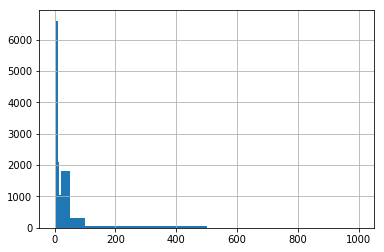

In [13]:
#Number of reviews by product
cnt_by_product = df[['asin','reviewText']].groupby('asin').agg('count')
cnt_by_product['reviewText'].hist(bins = [0,1,2,3,4,5,10,15,20,50,100,500,1000])

In [14]:
#Number of reviews by reviewer
cnt_by_reviewer = df[['reviewerID','reviewText']].groupby('reviewerID').agg('count').reset_index()

good_reviewers = cnt_by_reviewer[cnt_by_reviewer['reviewText']>4]
print(good_reviewers[:5])

good_products_by_review = cnt_by_product[cnt_by_product['reviewText']>4].reset_index()
print("good_products_by_review:\n", good_products_by_review[:5])

              reviewerID  reviewText
0  A012468118FTQAINEI0OQ           6
1   A0182108CPDLPRCXQUZQ           8
2  A026961431MGW0616BRS3           6
3  A034597326Z83X79S50FI           7
4  A04295422T2ZG087R17FX           5
good_products_by_review:
          asin  reviewText
0  0439893577          17
1  048645195X          11
2  0545496470           6
3  0615444172           6
4  0670010936          10


In [27]:
build_set = 0

product_buildset = pd.read_csv('./data/cluster_build_sets.csv', names=['asin','build_set'])

print("\nproduct_buildset:\n", product_buildset[:5])

products_in_buildset = product_buildset[product_buildset['build_set']==build_set]

print("\nproducts_in_buildset:\n", products_in_buildset[:5])

filters_merged = pd.merge(good_products_by_review, products_in_buildset[['asin','build_set']], on='asin')

print("\nfilters_merged({}):\n".format(len(filters_merged)), filters_merged[:5])

# Create a merged DF, joining the reviews data with the selected products with 5+ reviews in the a build set
df_merged = pd.merge(df[['asin','overall','reviewText']], filters_merged[['asin','build_set']], on='asin')
# Preprocess the reviews by HTML unescaping them
df_merged = df_merged.groupby(['asin','overall'], as_index=True)['reviewText'].apply(' '.join).apply(html.unescape).reset_index()
print("\n\ncleaned df columns:", list(df))
print("df_merged({}):\n".format(len(df_merged)), df_merged[:5])

# Create a merged DF, with asin, reviewerID and the overall rating per review
df_mean_merged = pd.merge(df[['asin','overall','reviewerID']], filters_merged[['asin']], on='asin').reset_index()
print("\n\ndf_mean_merged({}):\n".format(len(df_mean_merged)), df_mean_merged[:5])
# Aggregate the overall rating per revierwer
df_mean_merged = df_mean_merged.groupby(['asin','reviewerID'])['overall'].mean().reset_index()
print("\ndf_mean_merged({}):\n".format(len(df_mean_merged)), df_mean_merged[:5])
# Aggregate the per-reviewer mean rating for an overall per-product rating
df_mean_merged = df_mean_merged.groupby(['asin'])['overall'].mean().reset_index()
print("\ndf_mean_merged({}):\n".format(len(df_mean_merged)), df_mean_merged[:5])

# Create a merged DF, joining the metadata with the selected products with 5+ reviews in the a build set
md_merged = pd.merge(md[['asin','title','description']], df_mean_merged[['asin','overall']], on='asin')
print("\nmd_merged({}):\n".format(len(md_merged)), md_merged[:5])





product_buildset:
          asin  build_set
0  B002HWRQ9W          0
1  B00CUORE4Y          0
2  B007BFRTJM          0
3  B00EYN8QPA          0
4  B00B1JDB32          0

products_in_buildset:
          asin  build_set
0  B002HWRQ9W          0
1  B00CUORE4Y          0
2  B007BFRTJM          0
3  B00EYN8QPA          0
4  B00B1JDB32          0

filters_merged(11919):
          asin  reviewText  build_set
0  0439893577          17          0
1  048645195X          11          0
2  0545496470           6          0
3  0615444172           6          0
4  0670010936          10          0


cleaned df columns: ['overall', 'asin', 'reviewerID', 'reviewTime', 'reviewText', 'summary', 'unixReviewTime', 'helpful', 'reviewerName']
df_merged(34866):
          asin  overall                                         reviewText
0  0439893577      3.0  this is a nice magnetic board for the kids to ...
1  0439893577      4.0  Love the magnet easel... great for moving to d...
2  0439893577      5.0  I li

In [28]:
vectors_filepath = './data/vectors_each.{}.pytab'.format(build_set)
metadata_filepath = './data/metadata_each.{}.tsv'.format(build_set)
product_review_features_filepath = './data/product_features.{}.csv'.format(build_set)
product_attribute_features_filepath = './data/product_attribute_features.{}.csv'.format(build_set)

In [29]:
# Preprocess the reviews by HTML unescaping them

df_merged = df_merged.groupby(['asin','overall'], as_index=True)['reviewText'].apply(' '.join).apply(html.unescape).reset_index()
print("cleaned df columns:", list(df))


cleaned df columns: ['overall', 'asin', 'reviewerID', 'reviewTime', 'reviewText', 'summary', 'unixReviewTime', 'helpful', 'reviewerName']


In [30]:
print("Cleaned DF", df_merged[:5])
print("...{} records".format(len(df_merged)))

Cleaned DF          asin  overall                                         reviewText
0  0439893577      3.0  this is a nice magnetic board for the kids to ...
1  0439893577      4.0  Love the magnet easel... great for moving to d...
2  0439893577      5.0  I like the item pricing. My granddaughter want...
3  048645195X      3.0  The pictures in this book are very detailed an...
4  048645195X      4.0  Working with Mandala type coloring books can t...
...34866 records


In [31]:
def remove_file(file_path):
    if os.path.isfile(file_path):
        print("Removing file '{}'...".format(file_path))
        os.remove(file_path)

In [43]:
from string import punctuation

IGNORED_LEMMAS = ['-PRON-', 'PRON', 'i']
IGNORED_POS = ['PUNCT', 'DET']
MAX_FEATURES_PER_REVIEW = 10

def check_embedded_punctuation(input_str):
    """ Check for 2 sequential punctuation characters in a string """
    from string import punctuation
    
    punct_count = 0
    
    for char in input_str:
        if char in punctuation:
            punct_count += 1
            if punct_count == 2:
                return True
        else:
            punct_count = 0
            
    return False
        

def get_lemmatized_chunk(chunk):
    """ Filter a noun chunk to exclude IGNORED_LEMMAS and return the remaining text and a computed word vector. """
    processed_text = []
    vector = np.zeros(300)
    stop_count = 0
    non_stop_count = 0
    doc = chunk
    for token in doc:
        if (token.lemma_ not in IGNORED_LEMMAS) and (token.pos_ not in IGNORED_POS):            
            this_text = token.text.strip()
            
            # check if this token contains 2 or more sequential punctuation characters
            if check_embedded_punctuation(this_text):
                stop_count += 1
                continue
            else:  
                non_stop_count += 1
                vector = vector + token.vector

            #if this_text != token.text:
            #    processed_text.append(this_text)
            #else:
            processed_text.append(token.norm_.lower())   
        
    if (non_stop_count > 0) and (stop_count > 0):
        vector = np.divide(vector, non_stop_count)
    
    return " ".join(processed_text), vector


def get_vectors(text, nlp):
    """ <generator> Get embedding word vectors from a given text object. 
    Args
    ----------
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """          
    # first, strip out the stop words and lowercase the words
    text = ' '.join([word.lower() for word in text.split() if not word in stopWords])
    
    doc = nlp(text)
    #####
    # Next, iterate through the sentences and within those the noun chunks.
    # These noun chunks will be lemmatized and collected as potential features.
    #####
    
    collected_terms = []
    term_vector_map = {}
    
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
            #yield chunk.text, chunk.vector
            lemmatized_text, vect = get_lemmatized_chunk(chunk)
            if len(lemmatized_text) >0:
                collected_terms.append(lemmatized_text)
                term_vector_map[lemmatized_text] = vect
                
    term_rank = Counter(collected_terms)
    
    for ranked_term in term_rank.most_common(MAX_FEATURES_PER_REVIEW):
        term = ranked_term[0]
        yield term, term_vector_map[term]
        
def get_attribute_features(title, description, nlp):
    """ <generator> Get text features from a given product's title and description, in the same manner as for
    review text where features are the result of clustering
    
    Args
    ----------
    title (string)          text to be parsed, tokenized, and vectorized
    description (string)          text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)    pipeline to use for processing the input text
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """          
    
    if (title is not None) and (len(title)>0):
        for term, term_vector in get_vectors(title, nlp):
            yield term, term_vector
        
    if (description is not None) and (len(description)>0):
        for term, term_vector in get_vectors(description, nlp):
            yield term, term_vector
        

In [44]:
def write_vectors(word_vects, out_m, product, rating, processed_text, concept_vec):
    """Write product, rating, phrase and sense vector to metadata and vectors files"""
    phrase = processed_text
    sense_vector = concept_vec
    print('\t'.join([product, str(rating),phrase]), file=out_m)
    word_vects.append([sense_vector])


In [45]:
def write_product_attr_features(out_f, product, rating, processed_text, concept_vec):
    """Write product, mean rating, phrase and sense vector to product attribute features file"""
    phrase = processed_text
    sense_vector = concept_vec
    print('\t'.join([product, str(rating),phrase]), file=out_f)


In [51]:

remove_file(product_attribute_features_filepath)

total_start = time.time()

product_atts = md_merged

print("There are {} total products with at least 5 reviews each".format(len(product_atts)))

start_ind = 0
iteration_size = 1000
iter_limit = len(product_atts)
features_count = 0

print("\nCollecting word concept vectors for {} product titles & reviews...".format(iter_limit))
display_local_time()

with open(product_attribute_features_filepath, mode="a") as out_f:
    
    for iteration in range(int(iter_limit/iteration_size)+1):

        print("Starting iteration over products {}-{}...".format(start_ind + iteration*iteration_size,
                                                                start_ind + (iteration+1)*iteration_size-1))
        
        iter_start_time = time.time()
        
        processed_records = iteration*iteration_size
        
        this_iteration_size = min(iteration_size, len(product_atts)-processed_records)
        
        for iter_ind in range(this_iteration_size):
    
            product_ind = start_ind + iteration*iteration_size + iter_ind
        
            product = product_atts['asin'].iloc[product_ind]
            rating = product_atts['overall'].iloc[product_ind]
            title = product_atts['title'].iloc[product_ind]
            description = product_atts['description'].iloc[product_ind]
            
            attr_text = ' '.join([str(title), str(description)])
        
            if debug and (iteration == 0) and (iter_ind < 10):
                print("product: {}, rating: {}, title: '{}', description: '{}'".format(product, rating, title, description))
    
            #print(review)
            for processed_text, concept_vec in get_vectors(attr_text, nlp):
            
                # If there were no non-stop words in a given noun chunk, we will not add it to the vectors and metadata
                if (len(processed_text)>0):

                    write_product_attr_features(out_f, product, rating, processed_text, concept_vec)
                    features_count += 1           

        print("...completed processing {} products in {} seconds.".format(this_iteration_size, time.time()-iter_start_time))
    
print("...processed {} products in {} seconds, producing {} total product_features.".format(iteration*iteration_size+this_iteration_size, time.time()-total_start, features_count))


Removing file './data/product_attribute_features.0.csv'...
There are 11919 total products with at least 5 reviews each

Local time = 23:32
Starting iteration over products 0-999...
product: 0439893577, rating: 4.352941176470588, title: 'Little Red Tool Box: Magnetic Tabletop Learning Easel', description: 'The Magnetic Tabletop Learning Easel is one of the simplest&#x2014;yet also most versatile&#x2014;literacy tools around! No matter what your students&#x2019; skill level or classroom needs, there&#x2019;s something for everyone, from word and sentence-building to alphabet recognition. The sturdy easel stands alone on a tabletop, and then folds flat for easy storage. Its blank, magnetic write-on wipe-off surface can be used for teacher-led instruction, independent work, and partner activities.'
product: 048645195X, rating: 4.454545454545454, title: 'Dover Publications-Decorative Tile Designs Coloring Book', description: ''
product: 0545496470, rating: 3.6666666666666665, title: 'The Bo

In [ ]:
# The following boolean controls whether the index list and the output np matrix are build by the vectorizing process.
# This can be used if appropriate for small datasets, but the repeated stacking of numpy arrays is expensive.
# Otherwise, these item are already written out to the files in metadata_filepath and vectors_filepath, using PyTables.
build_vects = False

remove_file(vectors_filepath)
remove_file(metadata_filepath)

# Create a sample vector, to determine the word vect dimension of a single entry
sample_vect = [vec for vec in get_vectors("example", nlp)][0][1]
vect_dim = sample_vect.shape
print("Sample vect[{}]".format(vect_dim))
index = []
output = None
vectors_count = 0

total_start = time.time()

#good_reviews = df[df['reviewerID'].isin(good_reviewers['reviewerID'])][df['asin'].isin(good_products['asin'])]
#good_reviews = df[df['asin'].isin(good_products['asin']) & df['asin'].isin(products_in_buildset)]
good_reviews = df_merged

#print("There are {} total reviews for reviewers with at least 5 reviews each and products with at least 5 reviews each".format(len(good_reviews)))
print("There are {} total reviews for products with at least 5 reviews each".format(len(good_reviews)))

start_ind = 0
iteration_size = 1000
iter_limit = len(good_reviews)
#iter_limit = 10000


print("\nCollecting word concept vectors for {} product/rating/reviews...".format(iter_limit))
display_local_time()

with open_file(vectors_filepath, mode="w", title="Word Vectors") as out_v:
    
    atom = tables.Float32Atom(vect_dim[0])
    shape = (0,)
    filters = tables.Filters(complevel=5, complib='zlib')
    word_vect = out_v.create_earray(out_v.root, 'vector', atom, shape, filters=filters)

with open(metadata_filepath, 'a') as out_m, open_file(vectors_filepath, mode="a", title="Word Vectors") as out_v:
    
    print("Word Vectors: ", out_v)
    
    for iteration in range(int(iter_limit/iteration_size)+1):

        print("Starting iteration over reviews {}-{}...".format(start_ind + iteration*iteration_size,
                                                                start_ind + (iteration+1)*iteration_size-1))
        
        iter_start_time = time.time()
        
        processed_records = iteration*iteration_size
        
        this_iteration_size = min(iteration_size, len(good_reviews)-processed_records)
        
        for iter_ind in range(this_iteration_size):
    
            review_ind = start_ind + iteration*iteration_size + iter_ind
        
            #reviewer = good_reviews['reviewerID'].iloc[review_ind]
            product = good_reviews['asin'].iloc[review_ind]
            rating = good_reviews['overall'].iloc[review_ind]
            review = good_reviews['reviewText'].iloc[review_ind]
    
            #print(review)
            for processed_text, concept_vec in get_vectors(review, nlp):
            
                # If there were no non-stop words in a given noun chunk, we will not add it to the vectors and metadata
                if (len(processed_text)>0):

                    write_vectors(out_v.root.vector, out_m, product, rating, processed_text, concept_vec)
                    vectors_count += 1
                    
                    # If this run is not just writing to disk, but should also build the vectors
                    if build_vects:                    
                        # Append data to a list and a numpy array
                        index.append([product, rating, processed_text])
        
                        if output is None:
                            # Create an np.array with the first row as the retrieved word vector
                            output = np.array([concept_vec])
                        else:
                            # Append the next vector to the end of the vectors array
                            output = np.append(output, [concept_vec], axis=0)            

        print("...completed processing {} reviews in {} seconds.".format(this_iteration_size, time.time()-iter_start_time))
    
print("...processed {} reviews in {} seconds, producing {} word vectors.".format(iteration*iteration_size+this_iteration_size, time.time()-total_start, vectors_count))


In [ ]:
phrases = []
with open(metadata_filepath, 'r') as in_m:
    for line in in_m:
        phrase = line.split('\t')[2]
        phrases.append(phrase.strip())
        
phrase_count = Counter(phrases)

print("Here are the top {} phrases and their counts...".format(MAX_FEATURES_PER_REVIEW))

for counted_phrase in phrase_count.most_common(MAX_FEATURES_PER_REVIEW):
        phrase = counted_phrase[0]
        print(counted_phrase)


In [18]:
# Fit an HDBScan model using the sampled sense vectors

HDBSCAN_METRIC = 'manhattan'

with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:

    print("word_vectors: ", word_vectors)
    
    start = time.time()
    print("Creating word clusters from word vectors...")
    display_local_time()
    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, 
                                 metric=HDBSCAN_METRIC, gen_min_span_tree=True, prediction_data=True)
    hdbscanner.fit(word_vectors.root.vector)
    print("...completed clustering in {} seconds.".format(time.time()-start))

word_vectors:  ./data/vectors_each.0.pytab (File) 'Word Vectors'
Last modif.: 'Mon Jul  8 03:28:02 2019'
Object Tree: 
/ (RootGroup) 'Word Vectors'
/vector (EArray(309990,), shuffle, zlib(5)) ''

Creating word clusters from word vectors...
Local time = 13:08
...completed clustering in 70766.42185306549 seconds.


In [20]:
with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:
    vdim = len(word_vectors.root.vector)
    print("word-vectors{}: ".format(vdim), word_vectors.root.vector)
# Save the HDBScan model with a name indicating the number of word vectors clustered
    with open('./data/hdbscanner.{}.pickle'.format(build_set), 'wb') as pickle_file:
        pickle.dump(hdbscanner, pickle_file)

word-vectors309990:  /vector (EArray(309990,), shuffle, zlib(5)) ''


Condensing the linkage tree and then plotting...
...plotted condensed tree in 323.1499629020691 seconds.
Found 3498 clusters


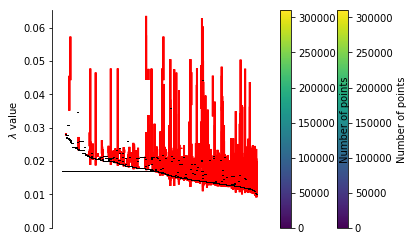

In [21]:
# Plot the condensed cluster tree


if plotting:
	start = time.time()
	print("Condensing the linkage tree and then plotting...")
	#hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
	hdbscanner.condensed_tree_.plot()
	hdbscanner.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
	print("...plotted condensed tree in {} seconds.".format(time.time()-start))
	tree = hdbscanner.condensed_tree_
	print("Found {} clusters".format(len(tree._select_clusters())))
	matplotlib.pyplot.show()

In [22]:
display_local_time()
print("Saving the CondensedTree to disk...")
start = time.time()
np.save("./data/condensedTree.{}.npy".format(build_set), tree)
print("...finished saving the CondensedTree in {} seconds.".format(time.time()-start))

Local time = 13:57
Saving the CondensedTree to disk...
...finished saving the CondensedTree in 0.03633880615234375 seconds.


In [23]:
print("Saving spacy language model to disk...")
display_local_time()
start = time.time()
nlp.to_disk("./data/spacy.language.model.nlp")
print("...finished saving spacy language model in {} seconds.".format(time.time()-start))

Saving spacy language model to disk...
Local time = 13:57
...finished saving spacy language model in 7.993974685668945 seconds.


In [24]:
def get_exemplars(cluster_id, condensed_tree):
    """ Collect and return the exemplar words for each cluster. """
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [25]:
with open(metadata_filepath, 'r') as in_m, open("data/metadata_ouch.tsv", 'w') as out_m:
    item = 0
    for line in in_m:
        fields = line.split('\t')
        if len(fields) > 1:
            print("Fields: ", fields)
            phrase = fields[2]
            phrase = phrase[0:-1:2]
            print("Phrase: ", phrase.split())
            fields[:2]=phrase[:len(phrase)-1]
            out_line = '\t'.join(fields)
            print("Out line: ", out_line)
            item += 1
            if item == 10:
                break

Fields:  ['0439893577', '3.0', 'note\n']
Phrase:  ['nt']
Out line:  n	note

Fields:  ['0439893577', '3.0', 'board\n']
Phrase:  ['bad']
Out line:  b	a	board

Fields:  ['0439893577', '3.0', 'mean\n']
Phrase:  ['ma']
Out line:  m	mean

Fields:  ['0439893577', '3.0', 'age\n']
Phrase:  ['ae']
Out line:  a	age

Fields:  ['0439893577', '3.0', 'quality magnet\n']
Phrase:  ['qaiymge']
Out line:  q	a	i	y	m	g	quality magnet

Fields:  ['0439893577', '3.0', 'mellissa doug\n']
Phrase:  ['mlis', 'og']
Out line:  m	l	i	s	 	o	mellissa doug

Fields:  ['0439893577', '3.0', 'mainly note\n']
Phrase:  ['mil', 'oe']
Out line:  m	i	l	 	o	mainly note

Fields:  ['0439893577', '3.0', 'most letter\n']
Phrase:  ['ms', 'etr']
Out line:  m	s	 	e	t	most letter

Fields:  ['0439893577', '3.0', 'name molly\n']
Phrase:  ['nm', 'ol']
Out line:  n	m	 	o	name molly

Fields:  ['0439893577', '3.0', 'play letter\n']
Phrase:  ['pa', 'etr']
Out line:  p	a	 	e	t	play letter



In [26]:
tree = hdbscanner.condensed_tree_

#print('Index, for reference:')
#for ind, entry in enumerate(index):
#    print("cluster: {}, ind: {}, entry: {}".format(hdbscanner.labels_[ind], ind, entry))

start = time.time()
print("Selecting clusters in tree...")
clusters = tree._select_clusters()
print("...finished selecting clusters in {} seconds.".format(time.time()-start))

initial_cluster_count = len(clusters)
print("Found {} clusters".format(initial_cluster_count))

index = []
all_points = []
labels = []

# iterate through the input metadata once, to collect all words and the word labels for the sampled points
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains index entries of of dimension {}'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		all_points.append(line.split('\t'))
		sample_this_row = True
		if sample_this_row:
			meta_line = line.split('\t')
			index.append(meta_line)
			if labels_words:
				labels.append(meta_line[2])
		curr_line += 1

print("All Points({}, {}): {}".format(len(all_points), len(all_points[0]), all_points[:5]))

# then, iterate through the input metadata again, to apply the cluster labels, if labels_words is False
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	curr_sample = 0

	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains {} index entries.'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		sample_this_row = True
		if sample_this_row:
			index.append(line.split('\t'))
			if not labels_words:
				labels.append("-")
			curr_sample += 1
		curr_line += 1


Selecting clusters in tree...
...finished selecting clusters in 2.1473007202148438 seconds.
Found 3498 clusters
File ./data/metadata_each.0.tsv contains index entries of of dimension 309990
All Points(309990, 3): [['0439893577', '3.0', 'note'], ['0439893577', '3.0', 'board'], ['0439893577', '3.0', 'mean'], ['0439893577', '3.0', 'age'], ['0439893577', '3.0', 'quality magnet']]
File ./data/metadata_each.0.tsv contains 309990 index entries.


In [27]:
print(hdbscanner.exemplars_[:10])

[array([[-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152],
       [-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152],
       [-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152],
       ...,
       [-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152],
       [-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152],
       [-0.25964,  0.38332, -0.06983, ...,  0.652  , -0.44635,  0.25152]],
      dtype=float32), array([[-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       ...,
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882]],
      dtype=float32), array([[ 0.848499  ,  0.049751  ,  0.5189

In [28]:
print(nlp.vocab.vectors.most_similar(hdbscanner.exemplars_[1]))

(array([17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942,
       17503079096101324942, 17503079096101324942, 17503079096101324942],
      dtype=uint64), array([15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005,
       15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005,
       15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005, 15005],
      dtype=int32), array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1. 

In [29]:
selected_clusters = []
cluster_map = {}
cluster_exemplar_map = {}

for i, c in enumerate(clusters):
    c_exemplars = get_exemplars(c, tree)

    point_label = None
    cluster_exemplars = set()
    for ind, ex_ind in enumerate(c_exemplars):
        #print("Exemplar -- {} : {}".format(index[ex_ind][0], index[ex_ind][2]))
        
        candidate_exemplar = index[ex_ind][2]
        candidate_exemplar = correct_spelling(candidate_exemplar)
        
        cluster_exemplars.add(index[ex_ind][2])
        if point_label is None:
            point_label = index[ex_ind][2]
    
    members = set()
    for label_ind, label in np.ndenumerate(hdbscanner.labels_):
        if label == i:
            members.add(index[label_ind[0]][2])
            if not labels_words:
                labels[label_ind[0]] = point_label
            
            #print("Member: {} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))
    
    exemplars_len = float(len(cluster_exemplars))
    members_len = float(len(members))
    
    # Look for clusters where the members outnumber the exemplars by 2 times
    if ((exemplars_len>0) and (len(members)>(2.0*exemplars_len))):
    
        example_cluster_exemplars = "|".join(cluster_exemplars)
        example_cluster_members = "|".join(members)
        
        selected_clusters.append((example_cluster_exemplars, example_cluster_members))
        # with the index of the cluster (treated as label by hdbscanner) as a key, store the index into selected_clusters
        cluster_map[str(i)] = len(selected_clusters)-1
        cluster_exemplar_map[str(i)] = cluster_exemplars

selected_cluster_count = len(selected_clusters)
if (selected_cluster_count>0):
    with open("./data/clusters.{}.txt".format(build_set), "w") as cluster_report:
        print("\nFound {} clusters ({}% of initially collected):".
          format(len(selected_clusters), 100.0*float(selected_cluster_count)/float(initial_cluster_count)), file=cluster_report)
        for example in selected_clusters:
            print("\nExemplars: {}".format(example[0]), file=cluster_report)
            print("Members: {}".format(example[1]), file=cluster_report)

with open(path_for_tf_metadata+'/metadata.{}.tsv'.format(build_set), 'w') as out_tf_meta:
    for label in labels:
        out_tf_meta.write(str(label)+'\n')
                                                                    
noise_count = sum([1 for label in hdbscanner.labels_ if label == -1])
print("\nThere were {} words that were considered noise.".format(noise_count))

np.save('./data/selected_clusters.{}.npy'.format(build_set), selected_clusters)



There were 117201 words that were considered noise.


In [30]:
print(hdbscanner.labels_[:10])

[2762 2485 3098 ... 2798   -1   -1]


In [31]:
def get_scored_exemplars(phrase, cluster_id):
    """ TODO -- Given a phase and a cluster_id (the label from hdbscanner for the phrase) return a set of scored exemplars.
    
    Note that this function doesn't yet return the results it should. The cell below does produce the right results though, and should be used instead.
    """
    scored_exemplars = {}
    exemplars = cluster_exemplar_map.get(str(cluster_id))
    if exemplars is None:
        return None
        exemplars = get_exemplars(cluster_id, hdbscanner.condensed_tree_)
        cluster_exemplars[str(cluster_id)]=exemplars
        
    phrase_doc = nlp(phrase)
    for exemplar in exemplars:
        exemp_doc = nlp(exemplar)
        scored_exemplars[exemplar]=phrase_doc.similarity(exemp_doc)
        
    return scored_exemplars

clustered_labels = [labels for labels, _ in cluster_exemplar_map.items()]

for ind, label in enumerate(hdbscanner.labels_):
    product = index[ind][0]
    phrase = index[ind][2]
    cluster_id = label
    
    if (cluster_id >= 0) and (cluster_id in clustered_labels):
        
        print("Product: {}, phrase: '{}', scored_exemplars: {}".format(product, phrase, 
                                                                       get_scored_exemplars(phrase, cluster_id,)))

In [32]:
print("selected_clusters:", selected_clusters[:5])
print("cluster_map:", [item for item in cluster_map.items()][:5])

def get_score(exem_tuple):
    return -exem_tuple[1]

with open(product_review_features_filepath, 'w') as prod_features_file:
    
    # create an empty dict in which to hold phrases we've already seen associated with a product
    visited_product_phrases = {}
    
    for ind, cluster_ind in enumerate(hdbscanner.labels_):
        # A non-negative hdbscanner label for a point indicates assignment to a cluster
        if cluster_ind >= 0:
            cluster_detail_ind = cluster_map.get(str(cluster_ind))
            if cluster_detail_ind is None:
                continue
            else:
                pass
                #print("Found detail for cluster {} : {}".format(cluster_ind, cluster_detail_ind))
            cluster_detail = selected_clusters[cluster_detail_ind]
            product = index[ind][0]
            rating = index[ind][1]
            phrase = index[ind][2]
            
            # see if we've already seen this phrase in this product, if so skip it
            already_visited_list = visited_product_phrases.get(product)
            if already_visited_list is None:
                visited_product_phrases[product]=[phrase]
            else:
                if phrase in already_visited_list:
                    continue
                else:
                    already_visited_list.append(phrase)
                    visited_product_phrases[product] = already_visited_list
                    
            phrase_doc = nlp(phrase)

            exemplars = cluster_detail[0]
            scored_exemplars = []
            for exemp in exemplars.split("|"):
                

                
                exemp_doc = nlp(exemp)
                ex_similarity = phrase_doc.similarity(exemp_doc)
                scored_exemplars.append((exemp, ex_similarity))
            scored_exemplars = sorted(scored_exemplars, key=get_score)
        
            #print("product:{}, rating:{}, phrase:'{}', cluster:{}, exemplars:{}".format(product, rating, phrase, cluster_ind, scored_exemplars))
            print("{}, {}, {}, '{}'".format(product, rating, cluster_ind, scored_exemplars[0][0], scored_exemplars), file=prod_features_file)

selected_clusters: [('posability|wrigley|theplayskool weeble|weeble', 'least two weeble|posability|weeble|new weeble|unpackage mine|great articulation posability|five weeble|stair weeble|theplayskool weeble|sockem bopper|good posability|wrigley'), ('lp2|zingo|fluxx', 'zombie fluxx|zingo card|original zingo|fluxx game|way bad fluxx|zingo|pirate fluxx|lp2|fluxx|rule fluxx|star fluxx'), ('van', 'outlet van|christmas.update second van|headrest van|front van|camper van|van'), ("it.you|fyou|you'll|that.i|it!i|it.if", "it.if teenager|it.if child|that.i relie|return itit|qute|this.i already lot|so ehst coulf|it!i|thank you!i|bassically block|dobut stack|tumblin|it.it debris|doestn|you'll|that.i|it.it|wrong hotwheel|it.if|it.if kid|it.you|fyou|obiviously poster need|last long eighter"), ('darth vader|boba fett', 'darth vadar|luke darth vader|darth maul|darth sidious|darth vader|name darth vader|fan boba fett|darth vader reminder|r2-d2 c-3po|boba fett|darth vader phrase|few darth vader piggie|da

In [62]:
# This ends up being a ***TON*** of labels, with the full run


for ind, label in enumerate(hdbscanner.labels_[:10]):
    if label >= 0:
        print("ind: {}, product: {}, label: {}".format(ind, index[ind][0], label))
            
        

['048645195X', '3.0', 'color pencil'] -
ind: 1, product: 048645195X, label: 995
ind: 2, product: 048645195X, label: 641
ind: 7, product: 048645195X, label: 472
ind: 12, product: 048645195X, label: 397
ind: 18, product: 048645195X, label: 472
ind: 21, product: 048645195X, label: 574
ind: 22, product: 048645195X, label: 402
ind: 23, product: 048645195X, label: 854
ind: 27, product: 048645195X, label: 1071
ind: 28, product: 048645195X, label: 1069
ind: 32, product: 0963679600, label: 574
ind: 33, product: 0963679600, label: 1068
ind: 34, product: 0963679600, label: 1020
ind: 35, product: 0963679600, label: 706
ind: 36, product: 0963679600, label: 574
ind: 37, product: 0963679600, label: 310
ind: 39, product: 0963679600, label: 472
ind: 40, product: 0963679600, label: 1046
ind: 41, product: 0963679600, label: 995
ind: 42, product: 0963679600, label: 1055
ind: 43, product: 0963679600, label: 574
ind: 44, product: 0963679600, label: 763
ind: 45, product: 0963679600, label: 871
ind: 46, produ

ind: 3136, product: B0001XNTJA, label: 416
ind: 3140, product: B0001XNTJA, label: 223
ind: 3141, product: B0001XNTJA, label: 566
ind: 3143, product: B0001XNTJA, label: 503
ind: 3145, product: B0001XNTJA, label: 136
ind: 3146, product: B0001XNTJA, label: 340
ind: 3147, product: B0001XNTJA, label: 632
ind: 3148, product: B0001XNTJA, label: 1028
ind: 3152, product: B0001XNTJA, label: 301
ind: 3153, product: B0001XNTJA, label: 582
ind: 3154, product: B0001XNTJA, label: 340
ind: 3155, product: B0001XNTJA, label: 774
ind: 3156, product: B0001XNTJA, label: 297
ind: 3158, product: B0001XNTJA, label: 981
ind: 3160, product: B0001XNTJA, label: 469
ind: 3162, product: B0001XNTJA, label: 1068
ind: 3163, product: B0001XNTJA, label: 644
ind: 3164, product: B0001XNTJA, label: 301
ind: 3165, product: B0001XNTJA, label: 909
ind: 3166, product: B0001XNTJA, label: 1039
ind: 3167, product: B0001XNTJA, label: 562
ind: 3168, product: B0001XNTJA, label: 859
ind: 3169, product: B0001XNTJA, label: 219
ind: 317

ind: 6134, product: B0009P5GUA, label: 577
ind: 6136, product: B0009P5GUA, label: 856
ind: 6138, product: B0009P5GUA, label: 989
ind: 6140, product: B0009P5GUA, label: 636
ind: 6144, product: B0009P5GUA, label: 703
ind: 6148, product: B0009P5GUA, label: 917
ind: 6152, product: B0009P5GUA, label: 1049
ind: 6155, product: B0009P5GUA, label: 654
ind: 6157, product: B0009P5GUA, label: 875
ind: 6158, product: B0009P5GUA, label: 578
ind: 6161, product: B0009P5YXO, label: 338
ind: 6162, product: B0009P5YXO, label: 892
ind: 6164, product: B0009P5YXO, label: 794
ind: 6165, product: B0009P5YXO, label: 890
ind: 6166, product: B0009P5YXO, label: 753
ind: 6169, product: B0009P5YXO, label: 1076
ind: 6170, product: B0009P5YXO, label: 1071
ind: 6171, product: B0009P5YXO, label: 1064
ind: 6172, product: B0009P5YXO, label: 753
ind: 6173, product: B0009P5YXO, label: 892
ind: 6174, product: B0009P5YXO, label: 989
ind: 6175, product: B0009P5YXO, label: 30
ind: 6176, product: B0009P5YXO, label: 881
ind: 617

ind: 10191, product: B000ICXHQ4, label: 807
ind: 10195, product: B000ICZ5IW, label: 403
ind: 10196, product: B000ICZ5IW, label: 1020
ind: 10199, product: B000ICZ5IW, label: 879
ind: 10201, product: B000ICZ5IW, label: 322
ind: 10203, product: B000ICZ5IW, label: 952
ind: 10205, product: B000ICZ5IW, label: 633
ind: 10206, product: B000ICZ5IW, label: 418
ind: 10212, product: B000ICZ5IW, label: 875
ind: 10214, product: B000ICZ5IW, label: 595
ind: 10218, product: B000ICZ5IW, label: 746
ind: 10219, product: B000IJBHOQ, label: 158
ind: 10222, product: B000IJBHOQ, label: 203
ind: 10223, product: B000IJBHOQ, label: 614
ind: 10225, product: B000IJBHOQ, label: 158
ind: 10226, product: B000IJBHOQ, label: 955
ind: 10227, product: B000IJBHOQ, label: 203
ind: 10228, product: B000IJBHOQ, label: 849
ind: 10231, product: B000IJBHOQ, label: 833
ind: 10232, product: B000IJBHOQ, label: 45
ind: 10233, product: B000IJBHOQ, label: 503
ind: 10234, product: B000IJBHOQ, label: 878
ind: 10236, product: B000IJBHOQ,

ind: 14348, product: B000ZPF8PC, label: 1067
ind: 14349, product: B000ZPF8PC, label: 847
ind: 14350, product: B000ZPF8PC, label: 152
ind: 14353, product: B000ZPF8PC, label: 925
ind: 14354, product: B000ZPF8PC, label: 842
ind: 14356, product: B000ZPF8PC, label: 201
ind: 14357, product: B000ZPF8PC, label: 445
ind: 14358, product: B000ZPF8PC, label: 890
ind: 14359, product: B000ZPF8RA, label: 231
ind: 14360, product: B000ZPF8RA, label: 348
ind: 14362, product: B000ZPF8RA, label: 607
ind: 14363, product: B000ZPF8RA, label: 1019
ind: 14364, product: B000ZPF8RA, label: 871
ind: 14367, product: B000ZPF8RA, label: 892
ind: 14369, product: B000ZPF8RA, label: 833
ind: 14371, product: B000ZPF8RA, label: 885
ind: 14373, product: B000ZPF8RA, label: 1019
ind: 14374, product: B000ZPF8RA, label: 866
ind: 14381, product: B000ZZV22U, label: 1075
ind: 14383, product: B000ZZV22U, label: 1051
ind: 14387, product: B000ZZV22U, label: 1072
ind: 14388, product: B000ZZV22U, label: 1060
ind: 14390, product: B000

ind: 19002, product: B001NVAEM4, label: 328
ind: 19003, product: B001NVAEM4, label: 1020
ind: 19004, product: B001NVAEM4, label: 239
ind: 19005, product: B001NVAEM4, label: 101
ind: 19006, product: B001NVAEM4, label: 991
ind: 19007, product: B001NVAEM4, label: 973
ind: 19011, product: B001NVAEM4, label: 877
ind: 19012, product: B001NVAEM4, label: 877
ind: 19013, product: B001NVAEM4, label: 101
ind: 19015, product: B001NVAEM4, label: 727
ind: 19017, product: B001NVAEM4, label: 672
ind: 19018, product: B001NVAEM4, label: 101
ind: 19021, product: B001NVAEM4, label: 1046
ind: 19022, product: B001NVAEM4, label: 877
ind: 19024, product: B001NVAEM4, label: 101
ind: 19025, product: B001NVAEM4, label: 289
ind: 19029, product: B001NVAEM4, label: 137
ind: 19031, product: B001NVAEM4, label: 1077
ind: 19032, product: B001O2QW9G, label: 1002
ind: 19033, product: B001O2QW9G, label: 1072
ind: 19036, product: B001O2QW9G, label: 315
ind: 19037, product: B001O2QW9G, label: 504
ind: 19041, product: B001O2

ind: 23635, product: B002RNQUSY, label: 875
ind: 23637, product: B002RNQUSY, label: 491
ind: 23639, product: B002RNU4OU, label: 877
ind: 23640, product: B002RNU4OU, label: 785
ind: 23641, product: B002RNU4OU, label: 418
ind: 23642, product: B002RNU4OU, label: 770
ind: 23643, product: B002RNU4OU, label: 319
ind: 23646, product: B002RNU4OU, label: 468
ind: 23648, product: B002RNU4OU, label: 877
ind: 23649, product: B002RNU4OU, label: 1070
ind: 23654, product: B002RNU4OU, label: 918
ind: 23655, product: B002RNU4OU, label: 293
ind: 23657, product: B002S4U8M6, label: 1074
ind: 23660, product: B002S4U8M6, label: 929
ind: 23662, product: B002S4U8M6, label: 1068
ind: 23665, product: B002S4U8M6, label: 280
ind: 23666, product: B002S4U8M6, label: 55
ind: 23667, product: B002S4U8M6, label: 1068
ind: 23669, product: B002S4U8M6, label: 58
ind: 23671, product: B002S4U8M6, label: 1075
ind: 23676, product: B002S4U8M6, label: 936
ind: 23677, product: B002S4U8M6, label: 280
ind: 23678, product: B002S4U8

ind: 26358, product: B0037UUZQY, label: 72
ind: 26359, product: B0037UUZQY, label: 501
ind: 26360, product: B0037UUZQY, label: 1010
ind: 26361, product: B0037UUZQY, label: 758
ind: 26362, product: B0037UUZQY, label: 1068
ind: 26363, product: B0037UUZQY, label: 897
ind: 26364, product: B0037UUZQY, label: 1079
ind: 26367, product: B0037UUZQY, label: 734
ind: 26368, product: B0037UUZQY, label: 1071
ind: 26369, product: B0037UUZQY, label: 1010
ind: 26370, product: B0037UUZQY, label: 501
ind: 26371, product: B0037UUZQY, label: 424
ind: 26372, product: B0037UUZQY, label: 332
ind: 26375, product: B0037UUZQY, label: 635
ind: 26378, product: B0037UUZQY, label: 75
ind: 26379, product: B0037UV02W, label: 1010
ind: 26380, product: B0037UV02W, label: 747
ind: 26381, product: B0037UV02W, label: 1071
ind: 26384, product: B0037UV02W, label: 1071
ind: 26385, product: B0037UV02W, label: 1071
ind: 26389, product: B0037UV02W, label: 665
ind: 26397, product: B0037UV02W, label: 82
ind: 26398, product: B0037

ind: 29018, product: B003ESZDY8, label: 618
ind: 29020, product: B003ESZDY8, label: 383
ind: 29025, product: B003ESZDY8, label: 920
ind: 29027, product: B003ESZDY8, label: 1008
ind: 29028, product: B003ESZDY8, label: 239
ind: 29032, product: B003ESZDY8, label: 527
ind: 29034, product: B003ESZDY8, label: 594
ind: 29036, product: B003ET17HY, label: 1077
ind: 29037, product: B003ET17HY, label: 909
ind: 29039, product: B003ET17HY, label: 618
ind: 29040, product: B003ET17HY, label: 920
ind: 29041, product: B003ET17HY, label: 1072
ind: 29042, product: B003ET17HY, label: 1071
ind: 29043, product: B003ET17HY, label: 852
ind: 29050, product: B003ET17HY, label: 890
ind: 29052, product: B003ET17HY, label: 239
ind: 29053, product: B003ET17HY, label: 654
ind: 29056, product: B003ET17HY, label: 920
ind: 29057, product: B003ET17HY, label: 1068
ind: 29058, product: B003ET17HY, label: 877
ind: 29059, product: B003ET17JC, label: 890
ind: 29064, product: B003ET17JC, label: 1027
ind: 29065, product: B003E

ind: 32763, product: B0042ESG38, label: 308
ind: 32765, product: B0042ESG38, label: 877
ind: 32769, product: B0042ESG38, label: 704
ind: 32771, product: B0042ESG38, label: 1009
ind: 32773, product: B0042ESG38, label: 258
ind: 32776, product: B0042ESG38, label: 1010
ind: 32777, product: B0042ESG38, label: 1068
ind: 32778, product: B0042ESG38, label: 1043
ind: 32779, product: B0042ESG38, label: 1075
ind: 32780, product: B0042ESG38, label: 1010
ind: 32781, product: B0042ESG38, label: 766
ind: 32782, product: B0042ESG38, label: 1074
ind: 32783, product: B0042ESG38, label: 920
ind: 32785, product: B0042ESGJW, label: 1010
ind: 32786, product: B0042ESGJW, label: 622
ind: 32787, product: B0042ESGJW, label: 1079
ind: 32789, product: B0042ESGJW, label: 1009
ind: 32790, product: B0042ESGJW, label: 55
ind: 32791, product: B0042ESGJW, label: 234
ind: 32797, product: B0042ESGJW, label: 311
ind: 32800, product: B0042ESGJW, label: 1063
ind: 32801, product: B0042ESGJW, label: 311
ind: 32802, product: B

ind: 37341, product: B004LLVHAG, label: 383
ind: 37347, product: B004LM72ZY, label: 878
ind: 37350, product: B004LM72ZY, label: 541
ind: 37357, product: B004LM72ZY, label: 920
ind: 37358, product: B004LM72ZY, label: 30
ind: 37359, product: B004LM72ZY, label: 543
ind: 37361, product: B004LM72ZY, label: 148
ind: 37362, product: B004LM72ZY, label: 1004
ind: 37363, product: B004LM72ZY, label: 457
ind: 37364, product: B004LM72ZY, label: 890
ind: 37365, product: B004LM72ZY, label: 307
ind: 37366, product: B004LM72ZY, label: 270
ind: 37368, product: B004LV9HNK, label: 478
ind: 37371, product: B004LV9HNK, label: 478
ind: 37373, product: B004LV9HNK, label: 892
ind: 37377, product: B004LV9HNK, label: 945
ind: 37379, product: B004LV9HNK, label: 263
ind: 37382, product: B004LV9HNK, label: 702
ind: 37386, product: B004LV9HNK, label: 1067
ind: 37387, product: B004LVCW5K, label: 1010
ind: 37389, product: B004LVCW5K, label: 1068
ind: 37392, product: B004LVCW5K, label: 1010
ind: 37393, product: B004LVC

ind: 41623, product: B004XPIPSC, label: 1010
ind: 41624, product: B004XPIPSC, label: 1025
ind: 41625, product: B004XPIPSC, label: 1010
ind: 41627, product: B004XPIPSC, label: 408
ind: 41629, product: B004XPIPSC, label: 1012
ind: 41632, product: B004XPIPSC, label: 731
ind: 41633, product: B004XPIPT6, label: 1072
ind: 41635, product: B004XPIPT6, label: 1068
ind: 41639, product: B004XPIPT6, label: 1071
ind: 41646, product: B004XPIPT6, label: 1010
ind: 41647, product: B004XPIPT6, label: 351
ind: 41648, product: B004XPIPT6, label: 1071
ind: 41649, product: B004XPIPT6, label: 394
ind: 41650, product: B004XPIPT6, label: 119
ind: 41651, product: B004XPIPT6, label: 229
ind: 41653, product: B004XPIPT6, label: 877
ind: 41655, product: B004XPIPT6, label: 383
ind: 41657, product: B004XPIQ5E, label: 115
ind: 41658, product: B004XPIQ5E, label: 719
ind: 41659, product: B004XPIQ5E, label: 1066
ind: 41661, product: B004XPIQ5E, label: 681
ind: 41662, product: B004XPIQ5E, label: 112
ind: 41664, product: B

ind: 46208, product: B0060RZ4IU, label: 890
ind: 46209, product: B0060RZ4IU, label: 16
ind: 46211, product: B0060RZ4IU, label: 65
ind: 46212, product: B0060RZ4JO, label: 313
ind: 46213, product: B0060RZ4JO, label: 845
ind: 46215, product: B0060RZ4JO, label: 1010
ind: 46216, product: B0060RZ4JO, label: 157
ind: 46219, product: B0060RZ4JO, label: 497
ind: 46220, product: B0060RZ4JO, label: 706
ind: 46221, product: B0060RZ4JO, label: 1068
ind: 46222, product: B0060RZ4JO, label: 560
ind: 46224, product: B0060RZ4JO, label: 429
ind: 46226, product: B0060RZ4JO, label: 580
ind: 46228, product: B0060RZ4JO, label: 313
ind: 46229, product: B0060RZ4JO, label: 558
ind: 46233, product: B0060RZ4JO, label: 235
ind: 46234, product: B0060RZ4JO, label: 588
ind: 46235, product: B0060RZ4JO, label: 1068
ind: 46237, product: B0060RZ4JO, label: 55
ind: 46238, product: B0060RZ4JO, label: 1043
ind: 46239, product: B0060RZ4JO, label: 1072
ind: 46240, product: B0060RZ4JO, label: 632
ind: 46241, product: B0060RZ4J

ind: 51246, product: B006UBLZNY, label: 253
ind: 51248, product: B006UBLZNY, label: 397
ind: 51249, product: B006UBLZNY, label: 1052
ind: 51251, product: B006UBLZNY, label: 1051
ind: 51255, product: B006UBLZNY, label: 706
ind: 51256, product: B006UBLZNY, label: 48
ind: 51257, product: B006UBLZNY, label: 472
ind: 51258, product: B006UBLZNY, label: 48
ind: 51259, product: B006UBLZNY, label: 596
ind: 51261, product: B006UBLZNY, label: 1064
ind: 51262, product: B006UBLZNY, label: 768
ind: 51263, product: B006UBLZNY, label: 971
ind: 51264, product: B006UBLZNY, label: 574
ind: 51265, product: B006UBLZNY, label: 396
ind: 51268, product: B006UBM1LE, label: 876
ind: 51271, product: B006UBM1LE, label: 544
ind: 51272, product: B006UBM1LE, label: 48
ind: 51276, product: B006UBM1LE, label: 542
ind: 51277, product: B006UBM1LE, label: 625
ind: 51279, product: B006UBM1LE, label: 396
ind: 51281, product: B006UBM1LE, label: 578
ind: 51282, product: B006UBM1LE, label: 587
ind: 51283, product: B006UBM1LE,

ind: 55947, product: B007XJE1AQ, label: 1074
ind: 55948, product: B007XJE1AQ, label: 13
ind: 55949, product: B007XJE1AQ, label: 255
ind: 55950, product: B007XJE1AQ, label: 890
ind: 55952, product: B007XJE1AQ, label: 883
ind: 55958, product: B007XJE1AQ, label: 729
ind: 55959, product: B007XJE1AQ, label: 13
ind: 55960, product: B007XJE1AQ, label: 1044
ind: 55962, product: B007XJE1AQ, label: 1002
ind: 55964, product: B007XJE1AQ, label: 255
ind: 55965, product: B007XJE1AQ, label: 994
ind: 55966, product: B007XJE1AQ, label: 871
ind: 55967, product: B007XJE1AQ, label: 1032
ind: 55968, product: B007XPLI38, label: 516
ind: 55969, product: B007XPLI38, label: 961
ind: 55971, product: B007XPLI38, label: 921
ind: 55972, product: B007XPLI38, label: 871
ind: 55973, product: B007XPLI38, label: 479
ind: 55974, product: B007XPLI38, label: 479
ind: 55977, product: B007XPLI38, label: 926
ind: 55978, product: B007XPLI38, label: 642
ind: 55979, product: B007XPLI38, label: 920
ind: 55980, product: B007XPLI3

ind: 60222, product: B008BRLV20, label: 262
ind: 60223, product: B008BRLV20, label: 302
ind: 60226, product: B008BRLZ44, label: 261
ind: 60227, product: B008BRLZ44, label: 385
ind: 60228, product: B008BRLZ44, label: 832
ind: 60230, product: B008BRLZ44, label: 1068
ind: 60231, product: B008BRLZ44, label: 116
ind: 60232, product: B008BRLZ44, label: 811
ind: 60233, product: B008BRLZ44, label: 135
ind: 60236, product: B008BRLZ44, label: 67
ind: 60238, product: B008BRLZ44, label: 1067
ind: 60239, product: B008BRLZ44, label: 385
ind: 60240, product: B008BRLZ44, label: 1038
ind: 60241, product: B008BRLZ44, label: 843
ind: 60249, product: B008BWZJ32, label: 1038
ind: 60250, product: B008BWZJ32, label: 1009
ind: 60251, product: B008BWZJ32, label: 1020
ind: 60253, product: B008BWZJ32, label: 449
ind: 60254, product: B008BWZJ32, label: 552
ind: 60259, product: B008BWZJ32, label: 1038
ind: 60260, product: B008BWZJ32, label: 1009
ind: 60261, product: B008BWZJ32, label: 552
ind: 60262, product: B008

ind: 64575, product: B009WLPEJA, label: 72
ind: 64576, product: B009WLPEJA, label: 495
ind: 64577, product: B009WLPEJA, label: 468
ind: 64579, product: B009WLPEJA, label: 866
ind: 64582, product: B009WLPEJA, label: 280
ind: 64583, product: B009WLPEJA, label: 468
ind: 64588, product: B009WLPEJA, label: 387
ind: 64589, product: B009WLPEJA, label: 711
ind: 64590, product: B009WLPEJA, label: 321
ind: 64592, product: B009WVWTEI, label: 302
ind: 64595, product: B009WVWTEI, label: 284
ind: 64596, product: B009WVWTEI, label: 163
ind: 64599, product: B009WVWTEI, label: 485
ind: 64600, product: B009WVWTEI, label: 302
ind: 64602, product: B009WVWTEI, label: 284
ind: 64603, product: B009WVWTEI, label: 1074
ind: 64604, product: B009WVWTEI, label: 1068
ind: 64606, product: B009WVWTEI, label: 301
ind: 64607, product: B009WVWTEI, label: 73
ind: 64608, product: B009WVWTEI, label: 1077
ind: 64610, product: B009WVWTEI, label: 875
ind: 64611, product: B009WVWTEI, label: 796
ind: 64616, product: B009WVWTEI

ind: 67976, product: B00B7QDQSE, label: 272
ind: 67984, product: B00B7QGRA8, label: 338
ind: 67985, product: B00B7QGRA8, label: 1070
ind: 67986, product: B00B7QGRA8, label: 1075
ind: 67987, product: B00B7QGRA8, label: 617
ind: 67988, product: B00B7QGRA8, label: 1072
ind: 67989, product: B00B7QGRA8, label: 1069
ind: 67990, product: B00B7QGRA8, label: 1041
ind: 67991, product: B00B7QGRA8, label: 310
ind: 67996, product: B00B7QGRA8, label: 1075
ind: 67999, product: B00B7QGRA8, label: 1002
ind: 68000, product: B00B7QGRA8, label: 1067
ind: 68002, product: B00B7QGRA8, label: 701
ind: 68007, product: B00B7QGRA8, label: 387
ind: 68014, product: B00B7QKEWU, label: 688
ind: 68015, product: B00B7QKEWU, label: 154
ind: 68016, product: B00B7QKEWU, label: 67
ind: 68017, product: B00B7QKEWU, label: 272
ind: 68019, product: B00B7QKEWU, label: 1004
ind: 68021, product: B00B7QKEWU, label: 67
ind: 68022, product: B00B7QKEWU, label: 1069
ind: 68023, product: B00B7QKEWU, label: 165
ind: 68025, product: B00

ind: 71621, product: B00C6Q5S44, label: 620
ind: 71622, product: B00C6Q5S44, label: 1068
ind: 71626, product: B00C6Q5S44, label: 1068
ind: 71627, product: B00C6Q5S44, label: 1009
ind: 71629, product: B00C6Q5S44, label: 190
ind: 71631, product: B00C6Q5S44, label: 1006
ind: 71633, product: B00C6Q5S44, label: 553
ind: 71636, product: B00C6Q5S44, label: 1038
ind: 71637, product: B00C6Q5S44, label: 1010
ind: 71638, product: B00C6Q5S44, label: 724
ind: 71639, product: B00C6Q5S44, label: 845
ind: 71641, product: B00C6Q5S44, label: 553
ind: 71642, product: B00C6Q5S44, label: 780
ind: 71643, product: B00C6Q5S44, label: 407
ind: 71644, product: B00C6Q5S44, label: 328
ind: 71645, product: B00C6Q5S44, label: 681
ind: 71646, product: B00C6Q62P8, label: 1010
ind: 71647, product: B00C6Q62P8, label: 341
ind: 71649, product: B00C6Q62P8, label: 592
ind: 71654, product: B00C6Q62P8, label: 738
ind: 71655, product: B00C6Q62P8, label: 1010
ind: 71656, product: B00C6Q62P8, label: 1010
ind: 71657, product: B0

ind: 75686, product: B00CZ3F276, label: 816
ind: 75692, product: B00CZ3F276, label: 553
ind: 75693, product: B00CZ3F276, label: 724
ind: 75694, product: B00CZ3F29Y, label: 553
ind: 75695, product: B00CZ3F29Y, label: 1068
ind: 75696, product: B00CZ3F29Y, label: 833
ind: 75698, product: B00CZ3F29Y, label: 311
ind: 75699, product: B00CZ3F29Y, label: 892
ind: 75700, product: B00CZ3F29Y, label: 961
ind: 75703, product: B00CZ3F29Y, label: 1008
ind: 75704, product: B00CZ3F29Y, label: 246
ind: 75705, product: B00CZ3F29Y, label: 553
ind: 75706, product: B00CZ3F29Y, label: 501
ind: 75707, product: B00CZ3F29Y, label: 875
ind: 75708, product: B00CZ3F29Y, label: 675
ind: 75710, product: B00CZ3F29Y, label: 1009
ind: 75711, product: B00CZ3F29Y, label: 755
ind: 75712, product: B00CZ3F29Y, label: 1068
ind: 75713, product: B00CZ3F29Y, label: 134
ind: 75714, product: B00CZ3F29Y, label: 18
ind: 75718, product: B00CZ3F29Y, label: 553
ind: 75720, product: B00CZ3F29Y, label: 657
ind: 75724, product: B00CZ3F2

ind: 80873, product: B00GBM73WE, label: 403
ind: 80875, product: B00GBMBOJ2, label: 619
ind: 80877, product: B00GBMBOJ2, label: 619
ind: 80879, product: B00GBMBOJ2, label: 64
ind: 80880, product: B00GBMBOJ2, label: 1052
ind: 80882, product: B00GBMBOJ2, label: 279
ind: 80884, product: B00GBMBOJ2, label: 1071
ind: 80885, product: B00GBMBOJ2, label: 1071
ind: 80887, product: B00GBMBOJ2, label: 971
ind: 80893, product: B00GBMBOJ2, label: 724
ind: 80894, product: B00GBMBOJ2, label: 64
ind: 80901, product: B00GDP58AS, label: 280
ind: 80902, product: B00GDP58AS, label: 1021
ind: 80903, product: B00GDP58AS, label: 877
ind: 80904, product: B00GDP58AS, label: 619
ind: 80906, product: B00GDP58AS, label: 280
ind: 80909, product: B00GDP58AS, label: 1064
ind: 80910, product: B00GDP58AS, label: 766
ind: 80915, product: B00GEEVM9E, label: 684
ind: 80920, product: B00GEEVM9E, label: 1039
ind: 80921, product: B00GEEVM9E, label: 1021
ind: 80926, product: B00GEEVM9E, label: 705
ind: 80928, product: B00GEE

In [19]:
# Prepare for a tensorboard visualization

import tensorflow as tf

output_init = tf.constant_initializer(output)

print('fitting shape:')
tf.reset_default_graph()
with tf.Session() :
    embedding_var = tf.get_variable('embedding_var', shape=[len(output), len(output[0])], initializer=tf.constant_initializer(output), dtype=tf.float32)
    embedding_var.initializer.run()
    print(embedding_var.eval())
    
sess = tf.Session()

sess.run(embedding_var.initializer)


with open(path_for_tf_ckpt,'w') as f:
    f.write("Index\tLabel\n")
    for ind,label_line in enumerate(index):
        label = '{}:{}:{}'.format(label_line[0], label_line[1], label_line[2])
        f.write("%d\t%s\n" % (ind,label))


/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


fitting shape:
[[ 0.0046832  -0.052254   -0.61886    ...  0.10458    -0.13108
   0.060235  ]
 [ 0.24339    -0.1187645  -0.30584    ... -0.16044849  0.2345235
   0.135445  ]
 [ 0.13475     0.028565   -0.31322    ... -0.095669   -0.053825
  -0.44506   ]
 ...
 [-0.09785     0.068775    0.06001    ...  0.06414    -0.206495
   0.1409    ]
 [-0.046274   -0.016358    0.15534    ... -0.071866    0.16842
  -0.14087   ]
 [ 0.064085    0.126205    0.06018    ...  0.074415    0.0133755
   0.204495  ]]


In [20]:
# Generate the tensorboard embedding visualization
# To view it, run command "tensorboard --port=6006 --logdir=./logdir" on your computer and then 
# open http://localhost:6006 in a browser.

from tensorflow.contrib.tensorboard.plugins import projector

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    # Create summary writer.
    writer = tf.summary.FileWriter(path_for_tf_metadata, sess.graph)
    # Initialize embedding_var
    sess.run(embedding_var.initializer)
    # Create Projector config
    config = projector.ProjectorConfig()
    # Add embedding visualizer
    embedding = config.embeddings.add()
    # Attache the name 'embedding'
    embedding.tensor_name = embedding_var.name
    # Metafile which is described later
    embedding.metadata_path = 'metadata.tsv'
    # Add writer and config to Projector
    projector.visualize_embeddings(writer, config)
    # Save the model
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, path_for_tf_ckpt, 1)

writer.close()

In [21]:
def generate_sample_vectors(text, nlp):
    """ Preprocess test text content, for predicting labels."""
    
    sample_index = []
    sample_vectors = None
    
    for concept_vec in get_vectors(text, nlp):
            
        # Append data to a list and a numpy array
        sample_index.append([product, rating, concept_vec[0]])
        
        if sample_vectors is None:
            # Create an np.array with the first row as the retrieved word vector
            sample_vectors = np.array([concept_vec[1]])
        else:
            # Append the next vector to the end of the vectors array
            sample_vectors = np.append(sample_vectors, np.array([concept_vec[1]]), axis=0)            
    
    return sample_index, sample_vectors

In [24]:

def get_sample_labels(cluster_ind):
    sample_labels = set()
    for word_ind in exemplars(clusters[cluster_ind], tree):
        exemplar_label = html.unescape(index[word_ind][2])
        sample_labels.add(exemplar_label)
        
    return sample_labels

In [25]:
sample_text = "I would buy this again. It was a very good deal and good for children 2-4. Usually, this is good fun and good for the whole family, brothers, sisters and friends. Another with a magnetic personality was buying sweets for his sweet. Something should be done to handle all shapes and sizes and enable then to be put together."

sample_index, sample_vectors = generate_sample_vectors(sample_text, nlp)

test_labels, strengths = hdbscan.approximate_predict(hdbscanner, sample_vectors)
print("test_labels: ",test_labels)

for ind, word_index in enumerate(sample_index):
    if (test_labels[ind] >0):
        print("Phrase '{}' is predicted to have labels {}.".format(word_index[2], get_sample_labels(test_labels[ind])))

test_labels:  [313 313  -1 119 332 264  -1  -1 231 168  -1]
Phrase '' is predicted to have labels {'others).finally', "i'm", 'codemaker', "i've", 'end.3', 'it!-', 'game:=it', 'd+', 'up.2', 'bakugans', 'play).given', 's107c', 'mathshark', 'me"', 'stiull', 'waterdeep', 'advantage?belfort', 'turr phennir', 'eurogamers', 'keyflower', 'school"', 'w/', 'mechanics.2', 'candy).i', 'd&d', 'you’ve', 'original!fluxx', 'dog.(if', 'irkusk', 'week).as', 'kid(s', 'this+', 'scattegories', 'endless!it', 'm&d', 'keepers-', 'boardgamer', 'incovenience', 'here.because', 'learn.3', 'of).overall', 'it.2', 'rules!i', 'rating!5.4', 'heart).some', 'points?i', "heli's", 'maneuver).that', 'it!a', 'allies."', "we've", 'inwit', 'reactiion', 'been!slinky', 'maeker', 'trendl', 'garven dreis', 'riot!munchkin', 'use.it', 'parchisi', 'lovedraft', 'quoridor', '-perfection', 'easilty', 'else.(3', 'ice"', 'long!-some', 'well!note', 'dc-9', 'watchitplayed', 'child(ren', 'don’t', 'sorts).also', 'favorites!)', 'colors$0.25/o

/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
